In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

In [2]:
data_singles = pd.read_csv("NGC2516_100m_selected_parallax_0.2_pm_inRA_1.5_pm_inDEC_1.5_CMD_cutted_18.6811_CMD_separated_singles.txt", delimiter=';', header=None)
data_singles.rename(columns = {21 : 'BP-RP, mag', 15 : 'G, mag'}, inplace=True)
data_singles = data_singles.apply(pd.to_numeric, errors='coerce')

data_iso = pd.read_csv("NGC2516_isochrone_1.2e8.txt", delimiter=' ')

In [30]:
data_singles = data_singles[data_singles['G, mag']>7]

In [6]:
def to_mf (a, b, c): #get mass of a starS with definite magnitude
    func = interp1d(a, b)
    return func(c)
data_singles['Mass'] = to_mf(data_iso['Gmag']+ 5 * np.log10(410) - 5 + 3.1*0.13*0.86, data_iso['Mass'], data_singles['G, mag'])

In [7]:
Mass_Func = pd.DataFrame(data = {'Mass' : np.linspace(data_singles[data_singles['G, mag']<=18]['Mass'].min(), data_singles['Mass'].max(), 1000)})

In [8]:
kde = KernelDensity( kernel='epanechnikov', bandwidth=0.15).fit(data_singles['Mass'][:, np.newaxis])
Mass_Func['MF_norm'] = np.exp(kde.score_samples(Mass_Func['Mass'][:, np.newaxis]))

Mass_Func['MF'] = Mass_Func['MF_norm'] / Mass_Func['MF_norm'].max()

In [9]:
Mass_Func.to_csv("NGC2516_Mass_function.txt", sep=';', index=False)

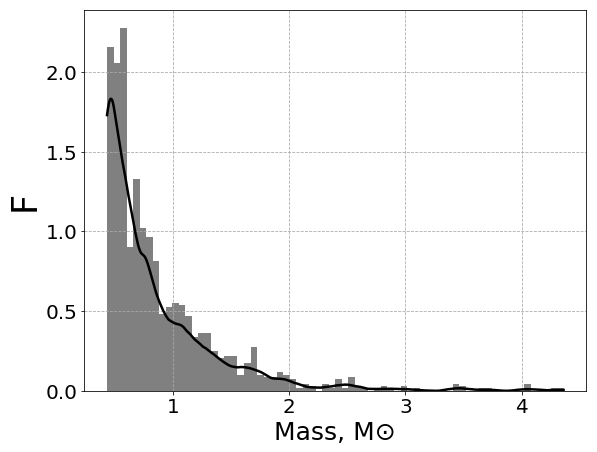

In [10]:
fig, ax = plt.subplots(figsize = (9, 7))
ax.hist(data_singles[data_singles['G, mag']<=18]['Mass'], bins=70, density = True, color = 'gray')

ax.plot(Mass_Func['Mass'], Mass_Func['MF_norm'], c ='black', lw = 2.5)
ax.grid(c='#aaaaaa', ls='--') 
ax.set_ylabel("F", size = 35)
ax.set_xlabel("Mass, M\u2299", size = 25)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.savefig("NGC2516_Mass_function.png")

In [11]:
from random import random
def neyman(data_1, data_2): #get q randomly from definite distribution
    x, yr = random()*data_1.max(), random()
    y = interp1d(data_1, data_2)
    if x >= data_1.min() and yr <= y(x):
        return [x, yr, 'under']
    else: 
        return [x, yr, 'upper']
            
neyman(Mass_Func['Mass'], Mass_Func['MF'])

[1.2982487021367421, 0.5555796559878671, 'upper']

In [12]:
def make_cluster (length, mf):
    _arr = []
    for  i in range (0,length):
        _arr.append(neyman(Mass_Func['Mass'], Mass_Func['MF']))
    _arr = np.array(_arr)
    _arr.transpose()
    return pd.DataFrame(data = {'Mass' : _arr[:,0], 'F':_arr[:,1], 'Name':_arr[:,2]})

cluster = make_cluster(5000, Mass_Func)
cluster = cluster[pd.to_numeric(cluster['Mass']) > Mass_Func['Mass'].min()]

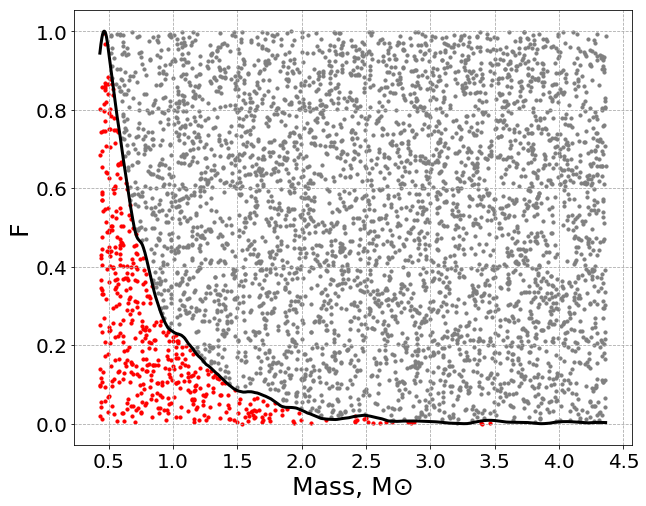

In [13]:
fig, ax = plt.subplots(figsize = (10, 8))
ax.scatter(pd.to_numeric(cluster[cluster['Name'] == 'under']['Mass']), pd.to_numeric(cluster[cluster['Name']=='under']['F']), c = 'red',s =10)
ax.scatter(pd.to_numeric(cluster[cluster['Name'] == 'upper']['Mass']), pd.to_numeric(cluster[cluster['Name']=='upper']['F']),c = 'grey', s =10)
ax.plot(Mass_Func['Mass'], Mass_Func['MF'], c ='black', lw = 3)
ax.grid(c='#aaaaaa', ls='--') 
ax.set_xlabel("Mass, M\u2299", size = 25)
ax.set_ylabel('F', size = 25)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.savefig("NGC2516_Mass_function_dots.png")

In [14]:
Mass_Func['Mass'].min()

0.4302667442170399

In [15]:
Mass_Func.to_csv("NGC2516_Mass_function.txt", sep=';', index=False)